# Ecuación de la Difracción Oblicua

En este notebook se va a abordar el problema de la Difracción Oblicua, dónde se calcularán los coeficientes de difracción en una zona de sombra que alberga un dique.

A partir de una demostración que puede consultarse en la referencia, Penney y Price (1952) obtuvieron una solución en polares para el coeficiente de difracción tal que:

$$
K_d = \left | I\left ( -\sqrt{\frac{4kr}{\pi}}\sin \frac{\alpha -\theta}{2}e^{-ikr\cos\left ( \alpha-\theta \right )} \right ) + I\left ( -\sqrt{\frac{4kr}{\pi}}\sin \frac{\alpha +\theta}{2}e^{-ikr\cos\left ( \alpha+\theta \right )} \right ) \right |
$$

dónde 

$$
I(\lambda)=\frac{1+C(\lambda)+S(\lambda)}{2}+i\frac{C(\lambda)-S(\lambda)}{2}
$$

y $C(\lambda)$ y $S(\lambda)$ son las integrales de Fresnel definidas como:

$$
C(\lambda)=\int_{0}^{\lambda}\cos\frac{\pi\lambda^2}{2}d\lambda \qquad S(\lambda)=\int_{0}^{\lambda}\sin\frac{\pi\lambda^2}{2}d\lambda
$$

## Importamos las librerías necesarias

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
# import maths
import os
import os.path as op
import sys

# arrays
import numpy as np
import xarray as xr
from sympy import *

# import matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
from IPython.display import HTML # diplay anim
matplotlib.rcParams['animation.embed_limit'] = 2**32
plt.style.use('dark_background')

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies
from lib.analitic import *

In [2]:
p_data = op.abspath(op.join(os.getcwd(),'..', '..', '..', 'data'))


## definimos las ecuaciones / variables

In [3]:
# load all the symbols
k, r, pi, alpha, theta = symbols('k r pi alpha theta')
lambdaa = symbols('lambda')

# we first define the K_d function
K_d = Function('K_d')(k,r,alpha,theta)
# but also other important functions
C = Function('C')(lambdaa)
C = integrate(cos(pi*lambdaa**2/2),(lambdaa,0,lambdaa))
S = Function('S')(lambdaa)
S = integrate(sin(pi*lambdaa**2/2),(lambdaa,0,lambdaa))
I_l = Function('I')(lambdaa)
I_l = (1+C+S)/2 + I*(C-S)/2

In [4]:
K_d

K_d(k, r, alpha, theta)

In [5]:
I_l

I*(sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 + sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4))

In [6]:
C

sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4))

In [7]:
S

3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4))

In [8]:
K_d = abs(I_l.subs(lambdaa,-sqrt(4*k*r/pi)*sin((alpha-theta)/2))*exp(-I*k*r*cos(alpha-theta)) + \
          I_l.subs(lambdaa,-sqrt(4*k*r/pi)*sin((alpha+theta)/2))*exp(-I*k*r*cos(alpha+theta)))

In [9]:
K_d

Abs((I*(-sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 - sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4)))*exp(-I*k*r*cos(alpha - theta)) + (I*(-sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 - sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4)))*exp(-I*k*r*cos(alpha + theta)))

## definir coordenadas y parámetros

In [10]:
# define polar coordinates
from sympy.abc import x, y
r = sqrt(x**2+y**2) # these are the polar coordinates
alpha = np.pi/2 - atan(x/y)

In [11]:
# fixed parameters for the wave
g_value = 9.8 # m / s^2
T_value = 8 # seconds
w_value = 2*np.pi/T_value
h_value = 5 # depth (meters)
# derived parameters for the wave
k_value = w_value**2/g_value
# waves.Waves(h_value,T=T_value).k # wave number
l_value = 2*np.pi/k_value

In [12]:
# get diffraction coefficients for (x,y)
x_range_nodes = (-400,800,50)
y_range_nodes = (1,1000,50)
k_diff = np.zeros((x_range_nodes[2],y_range_nodes[2]))

for i,xs in enumerate(np.linspace(*x_range_nodes)):
    
    for j,ys in enumerate(np.linspace(*y_range_nodes)):
            
        print(f'Calculating K_diff in ({xs},{ys}) -- in meters', end='\r')

        k_diff[i,j] = float(
            K_d.evalf(subs={
                'k':k_value,'theta':np.pi/2,'pi':np.pi,
                'r':r.evalf(subs={'x':xs,'y':ys}),
                'alpha': alpha.evalf(subs={'x':xs,'y':ys}),
            })
        )
        
xr.Dataset(
    {'K_diff':(('x','y'),k_diff)},
    coords={'x':np.linspace(*x_range_nodes),
            'y':np.linspace(*y_range_nodes)}
).K_diff.to_netcdf(op.join(p_data, 'diff_coeffs_test.nc'))

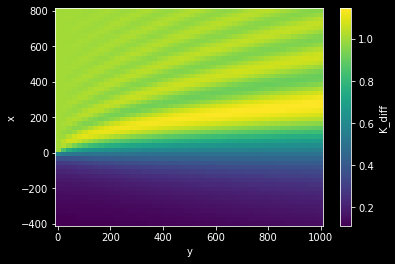

In [13]:
xr.open_dataarray(op.join(p_data, 'diff_coeffs_test.nc')).plot()
plt.show()

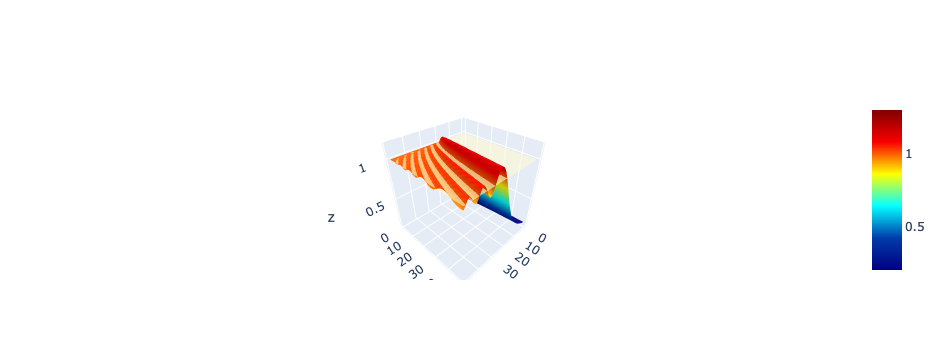

In [15]:
fig = go.Figure(data=[
    go.Surface(
        z=xr.open_dataarray(op.join(p_data, 'diff_coeffs_test.nc')).to_dataframe().values.reshape(50,50).T,
        colorscale='jet',cmin=0.2,cmax=1.3
    ),
    go.Surface(
        z=np.ones((50,50)),showscale=False,colorscale='earth',opacity=0.6
    )
])
fig.show()